In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as db
import os 

Connection to MySQL

In [2]:
conn = pd.read_json('connection.json', typ='series')
host = conn['host']
user = conn['user']
password = conn['password']
port = conn['port']

db_name = input('DB Name: ')
engine = db.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + port + '/' + db_name)

DB Name: 


Fine Query

In [ ]:
limit = 100_000
offset = 0
plane = 'rp7779'
year = 2022
df = []

while True:
    try:
        data = pd.read_sql(f"SELECT * FROM `{plane}-{year}` LIMIT {limit} OFFSET {offset}", engine)
        planeIDs = list(data['ID'].unique())
        dates = list(data['Date'].unique())
        minIndex = min(data['index'])
        maxIndex = max(data['index'])
        rm = list(data['RM'].unique())
        acft = list(data['Plane'].unique())
        data.to_parquet(f"{db_name}/{plane}-{year}/{offset}_{offset + limit}.parquet")
        print(f"ID: {planeIDs}, Dates: {dates}, IndexRange: ({minIndex, maxIndex})")
        print(f"Aircraft Included: {acft}, Registration Marking: {rm}")
        print(f"Index Counter: {offset} - {offset + limit}")
        print("-------------------------------------------------------------------")
        offset += limit
    except Exception as e:
        print(f"AN ERROR OCCURED: {e}")
        break

Read, Commpile, Save

In [45]:
directory = input('Directory: ')
filename_interval = int(input('Interval: '))

filenames = os.listdir(directory)
list_filenames = []
for filename in filenames:
    n1, n2 = filename.split('_')
    list_filenames.append(int(n1))
list_filenames = np.sort(list_filenames)

df = pd.DataFrame()
for each in list_filenames:
    data = pd.read_parquet(f'{directory}\\{each}_{each+filename_interval}.parquet')
    df = pd.concat([df, data])
    print(each)

Directory: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\PALB777\rp7777-2022\


In [ ]:
save_dir = input('Saving Directory: ')
save_name = input('Filename: ')
df.to_parquet(f"{save_dir}\\{save_name}.parquet")

Load

In [2]:
directory = input('Directory: ')
filename = input('Filename: ')
df = pd.read_parquet(f"{directory}/{filename}.parquet")

Directory: C:\Users\Kyle Carlo C. Lasala\Desktop\PAL\repo\Predicting-Fuel-Consumption\PALB777\compiled\
Filename: rp7777-2022


Fuel Saving Technique Detection

In [68]:
class B777:
    # INITIAL CHECK
    def check(data):
        # check phases
        phases = data['FLTPHASE'].unique()
        if ("ENGINE START" not in phases or  
            "TAXI OUT" not in phases or
            "DESCENT" not in phases or 
            "ROLL OUT" not in phases or
            "TAXI IN" not in phases):
            return False
        # check ID
        if data['ID'].nunique() != 1:
            return False
        # check columns
        col = data.columns
        if ("aLDGDWN" not in col):
            return False
        return True
    # CLEAN x
    def clean(data):
        data.index = data['index']
        data = data.drop('index',axis=1)
        # clean phases
        phases = ['ENGINE START', 'TAXI OUT', 'TAKEOFF ROLL', 'INITIAL CLMB', 'CLIMB', 'CRUISE', 'DESCENT',
                  'APPROACH', 'FLARE', 'ROLL OUT', 'TAXI IN', 'SHUTDOWN', 'POWER ON']
        # get indices of anomalous phases
        x_phases = []
        for each in data['FLTPHASE'].unique():
            if each not in phases:
                x_phases.append(each)
        print("X PHASES:", x_phases)
        x_indices = {}
        for each in x_phases:
            x_indices[each] = data[data['FLTPHASE'] == each].index
        # change the anomalous phases based on previous phase
        for each1 in x_indices:
            for each2 in x_indices[each1]:
                i = 0
                # loop back until clean phase is seen
                while ((each2 - i) != -1) and (data.loc[each2-i,'FLTPHASE'] in x_phases):
                    i+=1
                inferred_index = each2 - i
                if inferred_index != -1:
                    data.loc[each2, 'FLTPHASE'] = data.loc[inferred_index, 'FLTPHASE']
                # if reached the starting end, then loop forward until clean phase is seen
                else: 
                    i = 0
                    while((each2 + i) != len(data)) and (data.loc[each2+i, 'FLTPHASE'] in x_phases):
                        i+=1
                    inferred_index = each2 + i
                    data.loc[each2, 'FLTPHASE'] = data.loc[inferred_index, 'FLTPHASE']
        # phase sanity check
        if not all([True if each in phases else False for each in data['FLTPHASE'].unique()]):
            return False, 1, data
        # clean null
        data = data.ffill().bfill()    
        data = data.dropna(axis=1)
        # change the anomalous altitude (e.g. negative altitude)
        try:
            new_alt = []
            for each in data['aALTSTD1']:
                new_alt.append(0 if each < 0 else each)
            data['aALTSTD1'] = new_alt
        except:
            return False, 2, data
        # negative altitude sanity check
        if not ((data['aALTSTD1'] >= 0).all()):
            return False, 2, data
        # null sanity check
        if not data.notna().all().all():
            return False, 3, data
        # column count
        if not len(data.columns) != 67:
            return False, 4, data
        return True, 0, data
    
    def SETO(data):
        data = data[(data['FLTPHASE'] == 'TAXI OUT') | (data['FLTPHASE'] == 'ENGINE START')]
        data = data[['FLTPHASE','aLDGDWN','aFF1', 'aFF2']]
        init_TO = 0
        TO_detected = False
        init_E2 = 0
        E2_detected = False
        dnlck = True
        SETO = []
        for each in data.iloc:
            # detect downlock
            if each['aLDGDWN'] != 'DN & LCK':
                dnlck = False
            # detect start of Taxi-out
            if each['FLTPHASE'] == 'TAXI OUT' and not TO_detected:
                init_TO = each.name
                TO_detected = True
            # detect start of engine 2
            if each['aFF1'] > 0 and each['aFF2'] > 0 and not E2_detected:
                init_E2 = each.name
                E2_detected = True

            if (init_E2 - init_TO < 120 # if second engine delayed less than 120 seconds
                    and
                dnlck == True): # if still downlock
                SETO.append(1)
            else:
                SETO.append(0)
        SETO = pd.DataFrame({"SETO":SETO})
        SETO.index = data.index
        return SETO

    def SETI(data):
        data = data[(data['FLTPHASE'] == 'TAXI IN') | (data['FLTPHASE'] == 'SHUTDOWN')]
        SETI = []
        for each in data.iloc:
            # detect downlock and detech single engine use
            if each['aLDGDWN'] == 'DN & LCK' and (each['aFF1'] == 0 or each['aFF2'] == 0):
                SETI.append(1)
            else:
                SETI.append(0)
        SETI = pd.DataFrame({"SETI":SETI})
        SETI.index = data.index
        return SETI

In [69]:
d1 = df[df['ID']==458]
test = B777.check(d1)
isError, id_error, d1 = B777.clean(d1)
isError

X PHASES: ['**** 0 ****']


True

In [71]:
d1['FLTPHASE'].unique()

array(['ENGINE START', 'TAXI OUT', 'TAKEOFF ROLL', 'INITIAL CLMB',
       'CLIMB', 'CRUISE', 'DESCENT', 'APPROACH', 'FLARE', 'ROLL OUT',
       'TAXI IN', 'SHUTDOWN'], dtype=object)

<Axes: xlabel='index'>

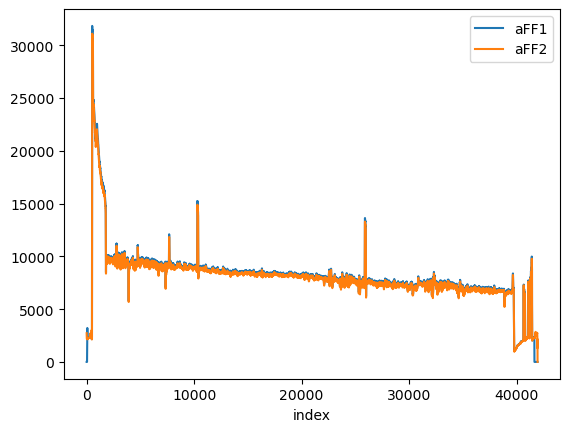

In [66]:
d1[['FLTPHASE','aFF1','aFF2']].plot()

In [61]:
d1[['FLTPHASE','aFF1','aFF2']]

,FLTPHASE,aFF1,aFF2
index,,,
41464,TAXI IN,2176.0,2080.0
41465,TAXI IN,2176.0,2080.0
41466,TAXI IN,2192.0,2080.0
41467,TAXI IN,2192.0,2096.0
41468,TAXI IN,2176.0,2096.0
...,...,...,...
41947,TAXI IN,0.0,2096.0
41948,TAXI IN,0.0,2128.0
41949,TAXI IN,0.0,2160.0


In [7]:
for each in df['ID'].unique():
    data = df[df['ID'] == each]
    data = data.reset_index().drop('index', axis=1)
    data = data[(data['FLTPHASE'] == 'TAXI OUT') | (data['FLTPHASE'] == 'ENGINE START')]
    try:
        print(f"ID: {each}", min(data[(data['aFF1'] > 0) & data['aFF2'] > 0].index))
    except:
        print("**ERROR**", each)

ID: 31 65
ID: 42 39
ID: 49 39
ID: 56 42
ID: 63 40
ID: 64 41
ID: 68 42
ID: 77 42
ID: 211 36
ID: 219 41
ID: 226 42
ID: 233 46
ID: 237 46
ID: 245 38
ID: 253 36
ID: 255 42
ID: 259 44
ID: 268 42
ID: 338 44
ID: 345 42
ID: 355 42
ID: 362 42
ID: 363 40
ID: 371 36
ID: 433 38
ID: 434 38
ID: 436 46
ID: 442 41
ID: 450 37
ID: 451 38
ID: 458 38
ID: 466 40
ID: 561 46
ID: 569 44
ID: 576 41
ID: 582 39
ID: 587 40
ID: 596 43
ID: 603 45
ID: 616 45
ID: 629 39
ID: 630 39
ID: 635 39
ID: 644 44
ID: 647 40
ID: 655 42
ID: 669 42
ID: 677 37
ID: 679 43
ID: 687 42
ID: 702 49
ID: 703 39
ID: 707 40
ID: 716 43
ID: 728 44
ID: 738 37
ID: 739 41
ID: 742 45
ID: 747 44
ID: 751 40
ID: 756 38
ID: 766 44
ID: 778 39
ID: 779 38
ID: 786 40
ID: 794 40
ID: 815 40
ID: 825 40
ID: 837 56
ID: 848 38
ID: 856 43
ID: 865 41
ID: 873 44
ID: 880 41
ID: 885 45
ID: 886 50
ID: 893 52
ID: 903 42
ID: 911 36
ID: 912 39
ID: 915 39
ID: 926 35
ID: 931 47
ID: 938 36
ID: 952 51
ID: 953 40
ID: 957 40
ID: 964 40
**ERROR** 1135
ID: 1203 45
ID: 1205 45
I

In [19]:
df[df['ID'] == 1135]['FLTPHASE'].unique()

array(['2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14'],
      dtype=object)

In [25]:
_,_,test_df = B777.clean(df[df['ID'] == 1303])

X PHASES: []


In [26]:
test_df

,Frame-Sf,SfCount,Time,aGMTHMS,FLTPHASE,aLATPOS2,aLONPOS2,aALTSTD1,aHEADINGM1,aPITCH,...,N12CMD,aAIRGND,CNTRDEN,LMDEFQPU,RMDEFQPU,LMFUFQPU,ID,Date,Plane,RM
index,,,,,,,,,,,,,,,,,,,,,
0,14-1,56,06:14:58,61458,ENGINE START,33.938892,-118.401947,100,-22.59,-0.48,...,20.81,GROUND,0.81,0.81,0.81,24.0,1303,2022-06-26,PAL103,RP7777
1,14-2,57,06:14:59,61459,ENGINE START,33.938892,-118.401947,101,-22.59,-0.48,...,20.81,GROUND,0.81,0.81,0.81,24.0,1303,2022-06-26,PAL103,RP7777
2,14-3,58,06:15:00,615 0,ENGINE START,33.938892,-118.401947,101,-22.59,-0.48,...,20.81,GROUND,0.81,0.81,0.81,24.0,1303,2022-06-26,PAL103,RP7777
3,14-4,59,06:15:01,615 1,ENGINE START,33.938892,-118.401947,100,-22.59,-0.48,...,20.81,GROUND,0.81,0.81,0.81,24.0,1303,2022-06-26,PAL103,RP7777
4,15-1,60,06:15:02,615 2,ENGINE START,33.938892,-118.401947,100,-22.59,-0.48,...,20.81,GROUND,0.81,0.81,0.81,24.0,1303,2022-06-26,PAL103,RP7777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52719,13193-4,52775,20:53:53,205353,TAXI IN,14.508815,120.998474,205,-138.43,0.00,...,21.66,GROUND,0.81,0.83,0.83,-3.0,1303,2022-06-26,PAL103,RP7777
52720,13194-1,52776,20:53:54,205354,TAXI IN,14.508815,120.998474,205,-138.43,0.00,...,21.66,GROUND,0.81,0.83,0.83,-3.0,1303,2022-06-26,PAL103,RP7777
52721,13194-2,52777,20:53:55,205355,TAXI IN,14.508815,120.998474,205,-138.43,0.00,...,21.53,GROUND,0.81,0.83,0.83,-3.0,1303,2022-06-26,PAL103,RP7777


In [203]:
def SETO(data):
    data = data[(data['FLTPHASE'] == 'TAXI OUT') | (data['FLTPHASE'] == 'ENGINE START')]
    data = data[['FLTPHASE','aLDGDWN','aFF1', 'aFF2']]
    init_TO = 0
    TO_detected = False
    init_E2 = 0
    E2_detected = False
    dnlck = True
    SETO = []
    for each in data.iloc:
        # detect downlock
        if each['aLDGDWN'] != 'DN & LCK':
            dnlck = False
        # detect start of Taxi-out
        if each['FLTPHASE'] == 'TAXI OUT' and not TO_detected:
            init_TO = each.name
            TO_detected = True
        # detect start of engine 2
        if each['aFF1'] > 0 and each['aFF2'] > 0 and not E2_detected:
            init_E2 = each.name
            E2_detected = True

        if (init_E2 - init_TO < 120 # if second engine delayed less than 120 seconds
                and
            dnlck == True): # if still downlock
            SETO.append(1)
        else:
            SETO.append(0)
    SETO = pd.DataFrame({"SETO":SETO})
    SETO.index = data.index
    return SETO

def SETI(data):
    data = data[(data['FLTPHASE'] == 'TAXI IN') | (data['FLTPHASE'] == 'SHUTDOWN')]
    SETI = []
    for each in data.iloc:
        # detect downlock and detech single engine use
        if each['aLDGDWN'] == 'DN & LCK' and (each['aFF1'] == 0 or each['aFF2'] == 0):
            SETI.append(1)
        else:
            SETI.append(0)
    SETI = pd.DataFrame({"SETI":SETI})
    SETI.index = data.index
    return SETI

In [211]:
d1.columns

Index(['Frame-Sf', 'SfCount', 'Time', 'aGMTHMS', 'FLTPHASE', 'aLATPOS2',
       'aLONPOS2', 'aALTSTD1', 'aHEADINGM1', 'aPITCH', 'aPITCH.1', 'aPITCH.2',
       'aPITCH.3', 'aPITCH.4', 'aROLL', 'aROLL.1', 'aAOAL1', 'aAOAL1.1',
       'aAOAL1.2', 'aAOAL1.3', 'aAOAR1', 'aAOAR1.1', 'aAOAR1.2', 'aAOAR1.3',
       'aCAS', 'aMACH', 'aMACH.1', 'aGS2', 'aGW', 'aN11', 'aN12', 'aFF1',
       'aFF2', 'aTHRANG1', 'aTHRANG1.1', 'aTHRANG2', 'aTHRANG2.1', 'aN21',
       'aN22', 'aTHREVD1', 'aTHREVD2', 'APU_ON', 'aTFQ', 'aFLAP', 'aFLAP1',
       'aFLAP2', 'aSLATSL', 'aSLATSR', 'aLDGDWN', 'aWNDDIR', 'aWNDSPD',
       'aAPENG', 'aATSENGA', 'aMACHIAS', 'aMACHSEL', 'N11CMD', 'N12CMD',
       'aAIRGND', 'CNTRDEN', 'LMDEFQPU', 'RMDEFQPU', 'LMFUFQPU', 'ID', 'Date',
       'Plane', 'RM'],
      dtype='object')

In [63]:
d1['FLTPHASE'].unique()

array(['TAXI IN', 'SHUTDOWN'], dtype=object)